Copyright 2021 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This colab showcases the usage of the Enformer model published in

**"Effective gene expression prediction from sequence by integrating long-range interactions"**

Žiga Avsec, Vikram Agarwal, Daniel Visentin, Joseph R. Ledsam, Agnieszka Grabska-Barwinska, Kyle R. Taylor, Yannis Assael, John Jumper, Pushmeet Kohli, David R. Kelley

**Note:** This colab will not yet work since the model isn't yet publicly available. We are working on enabling this and will update the colab accordingly.

### Steps

This colab demonstrates how to
- Make predictions with Enformer and reproduce Fig. 1d
- Compute contribution scores and reproduce parts of Fig. 2a
- Predict the effect of a genetic variant and reproduce parts of Fig. 3g
- Score multiple variants in a VCF

## Setup

**Start the colab kernel with GPU**: Runtime -> Change runtime type -> GPU

In [1]:
import tensorflow as tf
# Make sure the GPU is enabled
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'

AssertionError: Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU

In [ ]:
!pip install kipoiseq==0.5.2 --quiet > /dev/null
# You can ignore the pyYAML error

### Imports

In [ ]:
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/root/data/genome.fa'
clinvar_vcf = '/root/data/clinvar.vcf.gz'

In [ ]:
# Download targets from Basenji2 dataset
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

### Download files

Download and index the reference genome fasta file

Credit to Genome Reference Consortium: https://www.ncbi.nlm.nih.gov/grc

Schneider et al 2017 http://dx.doi.org/10.1101/gr.213611.116: Evaluation of GRCh38 and de novo haploid genome assemblies demonstrates the enduring quality of the reference assembly

In [ ]:
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data

Download the clinvar file. Reference:

Landrum MJ, Lee JM, Benson M, Brown GR, Chao C, Chitipiralla S, Gu B, Hart J, Hoffman D, Jang W, Karapetyan K, Katz K, Liu C, Maddipatla Z, Malheiro A, McDaniel K, Ovetsky M, Riley G, Zhou G, Holmes JB, Kattman BL, Maglott DR. ClinVar: improving access to variant interpretations and supporting evidence. Nucleic Acids Res . 2018 Jan 4. PubMed PMID: 29165669 .


In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz -O /root/data/clinvar.vcf.gz

### Code (double click on the title to show the code)

In [ ]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.

In [ ]:
# @title `variant_centered_sequences`

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)

  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

In [ ]:
# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

## Make predictions for a genetic sequenece

In [2]:
model = Enformer(model_path)

fasta_extractor = FastaStringExtractor(fasta_file)

NameError: name 'Enformer' is not defined

In [16]:
# @title Make predictions for an genomic example interval
target_interval = kipoiseq.Interval('chr15', 88_899_398, 88_913_319)  # @param

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

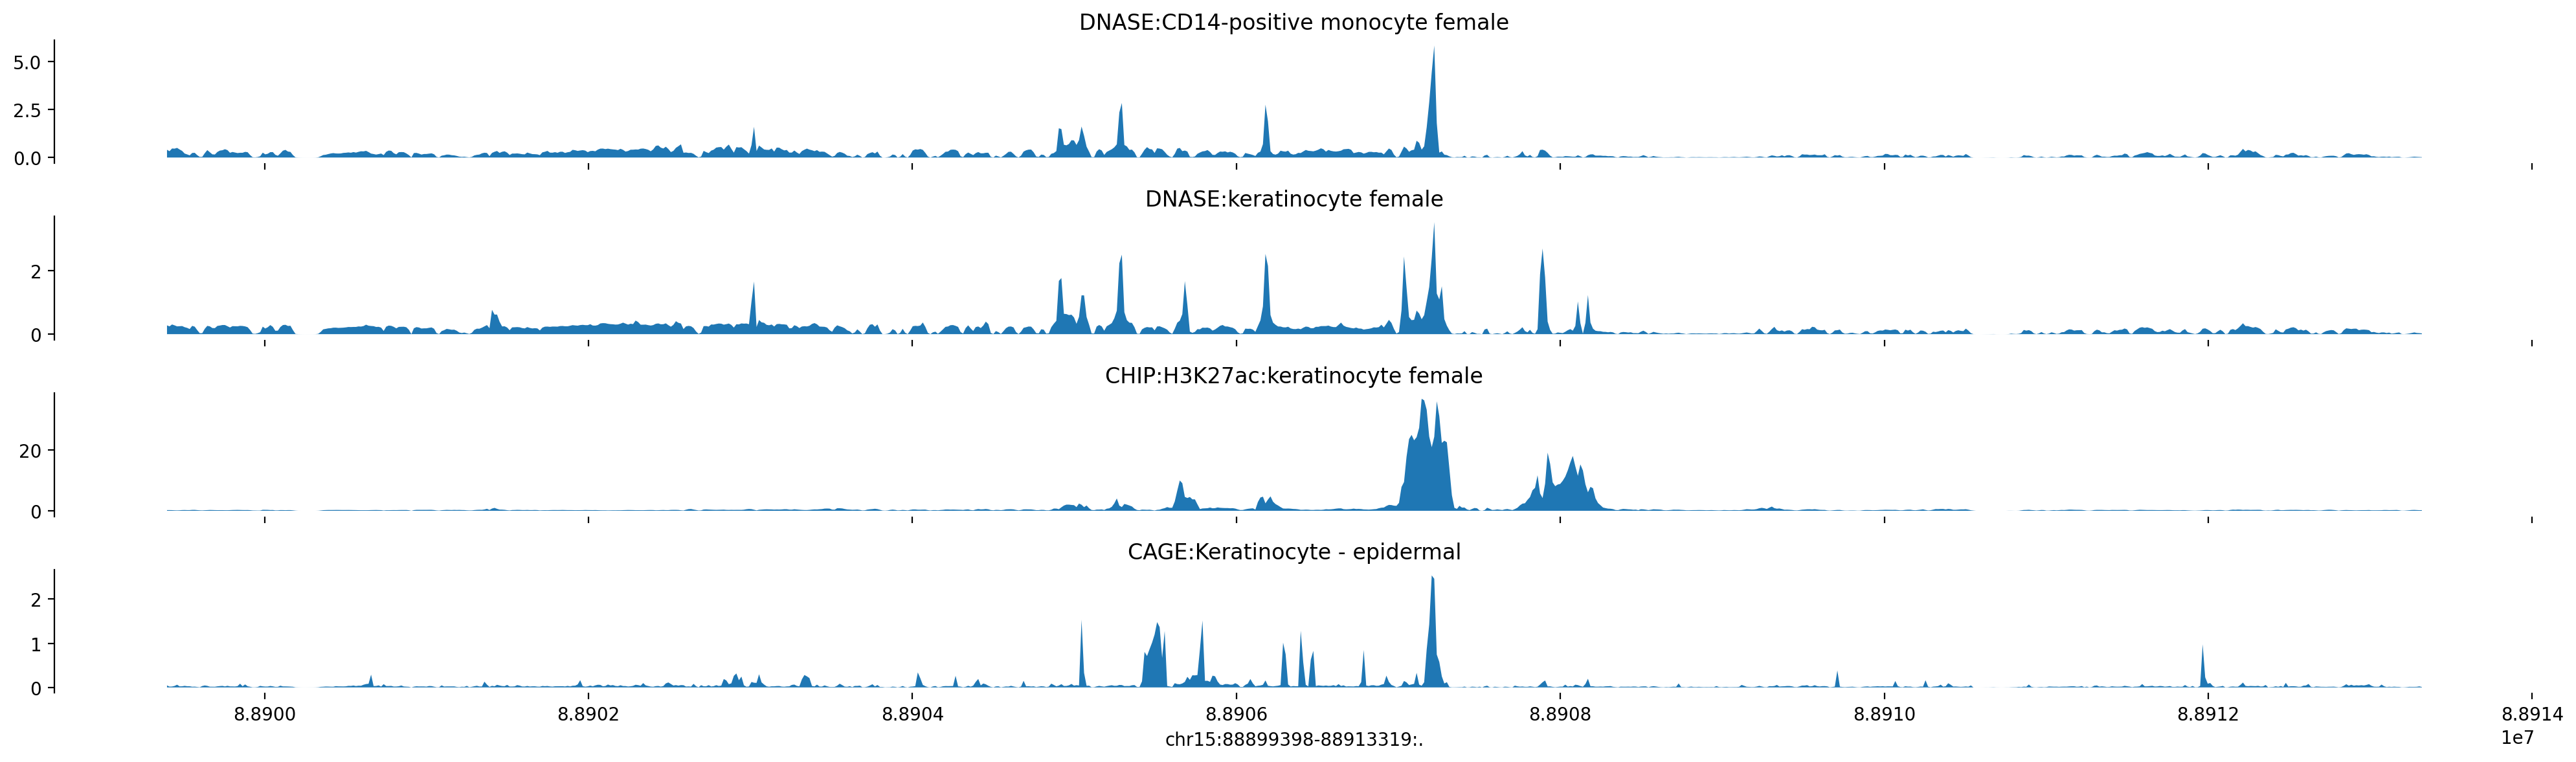

In [14]:
# @title Plot tracks
tracks = {'DNASE:CD14-positive monocyte female': predictions[:, 41],
          'DNASE:keratinocyte female': predictions[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
          'CAGE:Keratinocyte - epidermal': np.log10(1 + predictions[:, 4799])}
plot_tracks(tracks, target_interval)

## Contribution scores example

In [15]:
# @title Compute contribution scores
target_interval = kipoiseq.Interval('chr15', 88_899_398, 88_913_319)  # @param

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

target_mask = np.zeros_like(predictions)
for idx in [447, 448, 449]:
  target_mask[idx, 4828] = 1
  target_mask[idx, 5111] = 1
# This will take some time since tf.function needs to get compiled.
contribution_scores = model.contribution_input_grad(sequence_one_hot.astype(np.float32), target_mask).numpy()
pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis, :, np.newaxis], 128, 128, 'VALID')[0, :, 0].numpy()[1088:-1088]

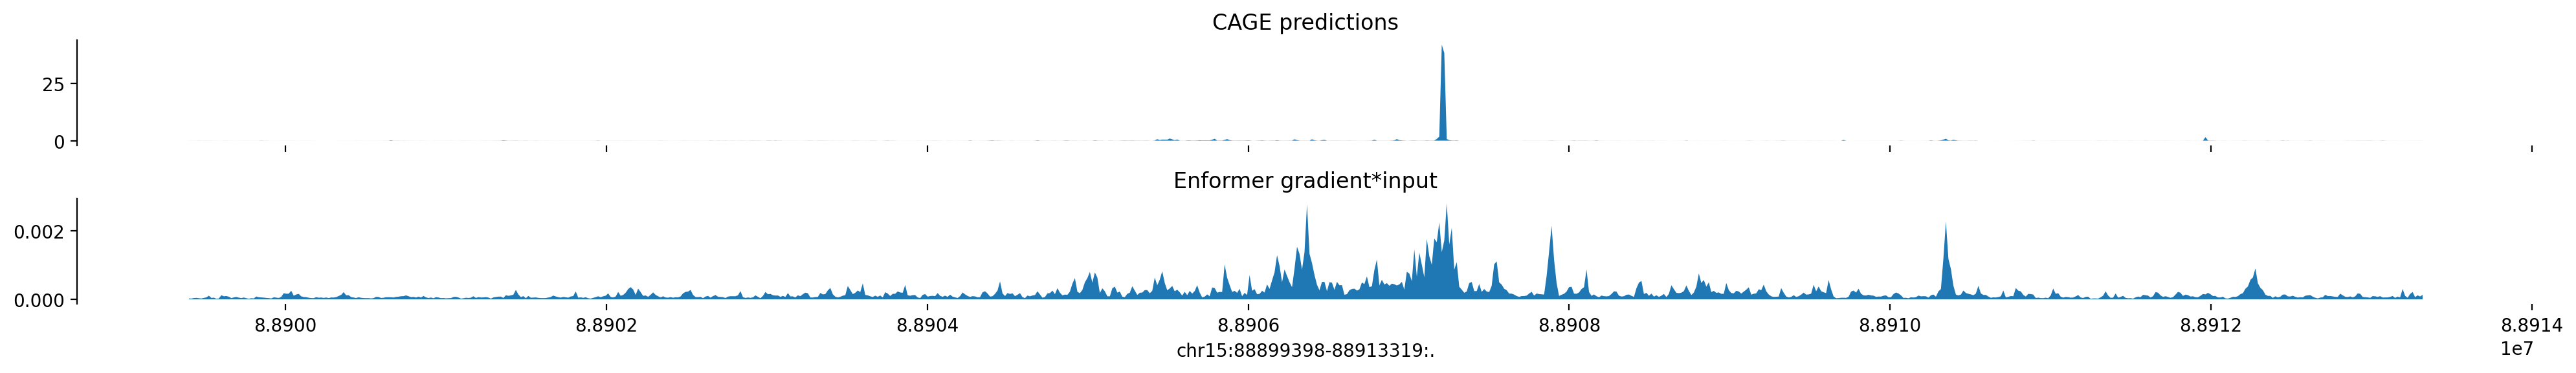

In [16]:
tracks = {'CAGE predictions': predictions[:, 4828],
          'Enformer gradient*input': np.minimum(pooled_contribution_scores, 0.03)}
plot_tracks(tracks, target_interval);

## Variant scoring example

In [17]:
# @title Score the variant
variant = kipoiseq.Variant('chr15', 88906856, 'C', 'T', id='rs8029053')  # @param

# Center the interval at the variant
interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
center = interval.center() - interval.start

reference = seq_extractor.extract(interval, [], anchor=center)
alternate = seq_extractor.extract(interval, [variant], anchor=center)

# Make predictions for the refernece and alternate allele
reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]
alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]

# Run through MFGE8 LD variants and score

In [21]:
# reference and interval is the same for all variants
TSS=88898683 ## TSS of MFGE8-201 from ensembl (neg strand)
interval = kipoiseq.Interval('chr15', TSS, TSS).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
center = interval.center() - interval.start
reference = seq_extractor.extract(interval, [], anchor=center)
reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]


In [39]:
# load variants of interest
df_variants=pd.read_csv('LD_all-cohorts.csv', header=0)
df_variants.head()

,Variation ID,Location,Distance from rs8029053,Consequence Type,r2,D',Phenotypes,GWAS_Trait_Category,Source,Ref Allele,Variant Allele
0,rs8029053,15:88906856-88906856,0,intron_variant,undefined,undefined,NaN,No trait reported,Ensembl,C,T
1,rs35729705,15:88903786-88903786,-3070,3_prime_UTR_variant,0.906439,0.975114,NaN,No trait reported,Ensembl,G,A
2,rs35729705,15:88903786-88903786,-3070,3_prime_UTR_variant,0.906439,0.975114,NaN,No trait reported,Ensembl,G,C
3,rs35729705,15:88903786-88903786,-3070,3_prime_UTR_variant,0.906439,0.975114,NaN,No trait reported,Ensembl,G,T
4,rs10852114,15:88903555-88903555,-3301,3_prime_UTR_variant,0.906439,0.975114,NaN,No trait reported,Ensembl,C,G


In [31]:
# load DF_targets map
df_targets_GOI=pd.read_csv('index_to_MFGE8_CAGE_interest.csv')
targets_of_interest=df_targets_GOI.index[df_targets_GOI['MFGE8_CAGE_interest']==1]
targets_of_interest

Index([4675, 4676, 4677, 4684, 4689, 4714, 4746, 4747, 4748, 4758, 4768, 4773,
       4778, 4801, 4814, 4815, 4816, 4817, 4818, 4819, 4947, 4948, 4949, 4976,
       5072],
      dtype='int64')

In [30]:
targets_of_interest

Index([4675, 4676, 4677, 4684, 4689, 4714, 4746, 4747, 4748, 4758, 4768, 4773,
       4778, 4801, 4814, 4815, 4816, 4817, 4818, 4819, 4947, 4948, 4949, 4976,
       5072],
      dtype='int64')

In [36]:

reference_prediction[:,targets_of_interest].shape

(896, 25)

In [93]:
reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]
enformer_results={}
enformer_results['reference_MFGE8']=reference_prediction[:,]

for idx in df_variants.index:
  rs=df_variants.loc[idx,'Variation ID']
  location=df_variants.loc[idx,'Location']
  print(location)
  chr='chr{}'.format(location.split(':')[0])
  pos=int(location.split(':')[1].split('-')[0])
  ref_allele=df_variants.loc[idx,'Ref Allele']
  var_allele=df_variants.loc[idx,'Variant Allele']

  variant = kipoiseq.Variant(chr, pos, ref_allele, var_allele, id=rs)
  alternate = seq_extractor.extract(interval, [variant], anchor=center)
  alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]
  enformer_results['{}-{}to{}_MFGE8'.format(rs,ref_allele,var_allele)]=alternate_prediction[:,]-reference_prediction[:,]


15:88906856-88906856
15:88903786-88903786
15:88903786-88903786
15:88903786-88903786
15:88903555-88903555
15:88893404-88893404
15:88893404-88893404
15:88893881-88893881
15:88893881-88893881
15:88893881-88893881
15:88902296-88902296
15:88893831-88893831
15:88902251-88902251
15:88900070-88900070
15:88900070-88900070
15:88903861-88903861
15:88903070-88903070
15:88893281-88893281
15:88893281-88893281
15:88902250-88902250
15:88905906-88905906
15:88905906-88905906
15:88903290-88903290
15:88903290-88903290
15:88903290-88903290
15:88893798-88893798
15:88893430-88893430
15:88893430-88893430
15:88899201-88899201
15:88899201-88899201
15:88893440-88893440
15:88893440-88893440
15:88893440-88893440
15:88902420-88902420
15:88902420-88902420


Interval(chrom='chr15', start=88702075, end=89095291, name='', strand='.', ...)

In [49]:

89095291-88702075

393216

In [48]:

len(list(range(88702075,89095291)))

393216

In [70]:

sum(enformer_results['rs8029053-CtoT_MFGE8'][:,0]==enformer_results['rs8029053-CtoT_MFGE8'][:,20])

0

In [72]:

enformer_results.keys()

dict_keys(['reference_MFGE8', 'rs8029053-CtoT_MFGE8', 'rs35729705-GtoA_MFGE8', 'rs35729705-GtoC_MFGE8', 'rs35729705-GtoT_MFGE8', 'rs10852114-CtoG_MFGE8', 'rs8024551-CtoA_MFGE8', 'rs8024551-CtoG_MFGE8', 'rs6496533-TtoA_MFGE8', 'rs6496533-TtoC_MFGE8', 'rs6496533-TtoG_MFGE8', 'rs1064085-TtoC_MFGE8', 'rs6496532-AtoG_MFGE8', 'rs56306739-GtoA_MFGE8', 'rs2090404-GtoA_MFGE8', 'rs2090404-GtoC_MFGE8', 'rs11073821-GtoA_MFGE8', 'rs12148547-GtoA_MFGE8', 'rs8043470-GtoC_MFGE8', 'rs8043470-GtoT_MFGE8', 'rs56127644-AtoG_MFGE8', 'rs3743388-CtoA_MFGE8', 'rs3743388-CtoG_MFGE8', 'rs4932447-CtoA_MFGE8', 'rs4932447-CtoG_MFGE8', 'rs4932447-CtoT_MFGE8', 'rs6496531-AtoG_MFGE8', 'rs8029546-TtoA_MFGE8', 'rs8029546-TtoG_MFGE8', 'rs2280215-CtoG_MFGE8', 'rs2280215-CtoT_MFGE8', 'rs8029559-TtoA_MFGE8', 'rs8029559-TtoC_MFGE8', 'rs8029559-TtoG_MFGE8', 'rs3743392-AtoC_MFGE8', 'rs3743392-AtoG_MFGE8'])

In [71]:

enformer_results['rs8029053-CtoT_MFGE8'][500:520,0]

array([ 0.1855594 ,  0.23106247,  0.27182567, 12.053377  ,  7.9751306 ,
        0.20877402,  0.09800249,  0.1456928 ,  0.13960809,  0.17628975,
       13.544925  ,  3.9524858 ,  0.20896682,  0.15677598,  7.541958  ,
       13.022083  ,  0.27278134,  0.31967592,  0.22621745,  0.21560183],
      dtype=float32)

In [78]:
enformer_results['reference_MFGE8'][:,0].shape

(896,)

In [79]:

896/2

448.0

In [88]:

interval

Interval(chrom='chr15', start=88702075, end=89095291, name='', strand='.', ...)

In [91]:

(89095291-88702075)/896

438.85714285714283

In [104]:
rs8029053_max_vals=enformer_results['rs8029053-CtoT_MFGE8'].max(axis=0)
map_max={i:rs8029053_max_vals[i] for i in range(len(rs8029053_max_vals))}
df_targets['rs8029053_max_vals']=df_targets.index.map(map_max)

In [108]:
rs3743388_max_vals=enformer_results['rs3743388-CtoA_MFGE8'].max(axis=0)
map_max={i:rs3743388_max_vals[i] for i in range(len(rs3743388_max_vals))}
df_targets['rs3743388_max_vals']=df_targets.index.map(map_max)

In [105]:
rs8029053_min_vals=enformer_results['rs8029053-CtoT_MFGE8'].min(axis=0)
map_min={i:rs8029053_min_vals[i] for i in range(len(rs8029053_min_vals))}
df_targets['rs8029053_min_vals']=df_targets.index.map(map_min)

In [103]:
df_targets.loc[4813,'description']

'CAGE:Skeletal muscle cells differentiated into Myotubes - multinucleated,'

In [ ]:

df_targets.sort_values(by='rs8029053_min_vals', ascending=True).head(40)

In [109]:
df_targets.sort_values(by='rs3743388_max_vals', ascending=False).head(40)

,index,genome,identifier,file,clip,scale,sum_stat,description,rs8029053_max_vals,rs8029053_min_vals,rs3743388_max_vals
5274,5274,0,CNhs13816,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:Olfactory epithelial cells,",0.075386,-4.220688,6.069687
4800,4800,0,CNhs12013,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:Preadipocyte - omental,",0.048233,-4.987183,5.310181
4802,4802,0,CNhs12050,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:Synoviocyte,",0.063873,-4.667252,4.981461
4793,4793,0,CNhs11969,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:Adipocyte - breast,",0.039345,-3.594326,3.708755
4691,4691,0,CNhs10629,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:skeletal muscle, adult, pool1",0.109438,-0.668135,3.592590
4795,4795,0,CNhs11054,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:Adipocyte - omental,",0.039299,-3.568840,3.568207
4869,4869,0,CNhs11344,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:Mesenchymal Stem Cells - bone marrow,",0.114534,-0.245216,3.484604
4903,4903,0,CNhs11923,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:Chondrocyte - de diff,",0.055779,-3.443481,3.466072
5116,5116,0,CNhs12342,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:Lens Epithelial Cells,",0.077339,-0.384915,3.455719
4784,4784,0,CNhs12019,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:Nucleus Pulposus Cell,",0.213387,-0.907732,3.431091


In [84]:

df_targets

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348
...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727


In [85]:
for x in targets_of_interest:
  print(x)
  print(df_targets.loc[x,:].description)

4675
CAGE:Clontech Human Universal Reference Total RNA, pool1
4676
CAGE:SABiosciences XpressRef Human Universal Total RNA, pool1
4677
CAGE:Universal RNA - Human Normal Tissues Biochain, pool1
4684
CAGE:heart, adult, pool1
4689
CAGE:placenta, adult, pool1
4714
CAGE:heart, fetal, pool1
4746
CAGE:Endothelial Cells - Aortic,
4747
CAGE:Smooth Muscle Cells - Aortic,
4748
CAGE:Smooth Muscle Cells - Umbilical artery,
4758
CAGE:CD14+ Monocytes,
4768
CAGE:Smooth Muscle Cells - Brain Vascular,
4773
CAGE:Smooth Muscle Cells - Colonic,
4778
CAGE:Fibroblast - Aortic Adventitial,
4801
CAGE:Smooth Muscle Cells - Internal Thoracic Artery,
4814
CAGE:Smooth Muscle Cells - Brachiocephalic,
4815
CAGE:Smooth Muscle Cells - Carotid,
4816
CAGE:Smooth Muscle Cells - Coronary Artery,
4817
CAGE:Smooth Muscle Cells - Pulmonary Artery,
4818
CAGE:Smooth Muscle Cells - Subclavian Artery,
4819
CAGE:Smooth Muscle Cells - Umbilical Artery,
4947
CAGE:heart, adult, diseased post-infarction,
4948
CAGE:heart, adult, diseas

In [75]:
enformer_keys_no_ref=['rs8029053-CtoT_MFGE8', 'rs35729705-GtoA_MFGE8', 'rs35729705-GtoC_MFGE8', 'rs35729705-GtoT_MFGE8', 'rs10852114-CtoG_MFGE8', 'rs8024551-CtoA_MFGE8', 'rs8024551-CtoG_MFGE8', 'rs6496533-TtoA_MFGE8', 'rs6496533-TtoC_MFGE8', 'rs6496533-TtoG_MFGE8', 'rs1064085-TtoC_MFGE8', 'rs6496532-AtoG_MFGE8', 'rs56306739-GtoA_MFGE8', 'rs2090404-GtoA_MFGE8', 'rs2090404-GtoC_MFGE8', 'rs11073821-GtoA_MFGE8', 'rs12148547-GtoA_MFGE8', 'rs8043470-GtoC_MFGE8', 'rs8043470-GtoT_MFGE8', 'rs56127644-AtoG_MFGE8', 'rs3743388-CtoA_MFGE8', 'rs3743388-CtoG_MFGE8', 'rs4932447-CtoA_MFGE8', 'rs4932447-CtoG_MFGE8', 'rs4932447-CtoT_MFGE8', 'rs6496531-AtoG_MFGE8', 'rs8029546-TtoA_MFGE8', 'rs8029546-TtoG_MFGE8', 'rs2280215-CtoG_MFGE8', 'rs2280215-CtoT_MFGE8', 'rs8029559-TtoA_MFGE8', 'rs8029559-TtoC_MFGE8', 'rs8029559-TtoG_MFGE8', 'rs3743392-AtoC_MFGE8',
                      'rs3743392-AtoG_MFGE8']

In [92]:
enformer_results

{'reference_MFGE8': array([[0.14324994, 0.01074504, 0.01194243, ..., 0.02922421, 0.00114078,
         0.00766214],
        [0.06725165, 0.0104842 , 0.01120757, ..., 0.02417442, 0.0013691 ,
         0.00906223],
        [0.13103066, 0.01412067, 0.01498205, ..., 0.02668437, 0.00178491,
         0.01090031],
        ...,
        [0.12951192, 0.06849112, 0.07808743, ..., 0.0612728 , 0.00508595,
         0.02865498],
        [0.00692138, 0.00321277, 0.00349061, ..., 0.00418777, 0.00050552,
         0.00207203],
        [0.01285851, 0.00597184, 0.00646503, ..., 0.00647445, 0.00057066,
         0.00675883]], dtype=float32),
 'rs8029053-CtoT_MFGE8': array([[0.1432438 , 0.01074604, 0.0119438 , ..., 0.02922719, 0.0011407 ,
         0.00766246],
        [0.06724801, 0.01048493, 0.01120851, ..., 0.02417649, 0.00136909,
         0.00906281],
        [0.13101374, 0.01412153, 0.01498335, ..., 0.02668785, 0.00178477,
         0.01090073],
        ...,
        [0.12952201, 0.06850097, 0.07809926, ..., 

[Text(0, 0, 'rs8029053-CtoT_MFGE8'),
 Text(0, 1, 'rs35729705-GtoA_MFGE8'),
 Text(0, 2, 'rs35729705-GtoC_MFGE8'),
 Text(0, 3, 'rs35729705-GtoT_MFGE8'),
 Text(0, 4, 'rs10852114-CtoG_MFGE8'),
 Text(0, 5, 'rs8024551-CtoA_MFGE8'),
 Text(0, 6, 'rs8024551-CtoG_MFGE8'),
 Text(0, 7, 'rs6496533-TtoA_MFGE8'),
 Text(0, 8, 'rs6496533-TtoC_MFGE8'),
 Text(0, 9, 'rs6496533-TtoG_MFGE8'),
 Text(0, 10, 'rs1064085-TtoC_MFGE8'),
 Text(0, 11, 'rs6496532-AtoG_MFGE8'),
 Text(0, 12, 'rs56306739-GtoA_MFGE8'),
 Text(0, 13, 'rs2090404-GtoA_MFGE8'),
 Text(0, 14, 'rs2090404-GtoC_MFGE8'),
 Text(0, 15, 'rs11073821-GtoA_MFGE8'),
 Text(0, 16, 'rs12148547-GtoA_MFGE8'),
 Text(0, 17, 'rs8043470-GtoC_MFGE8'),
 Text(0, 18, 'rs8043470-GtoT_MFGE8'),
 Text(0, 19, 'rs56127644-AtoG_MFGE8'),
 Text(0, 20, 'rs3743388-CtoA_MFGE8'),
 Text(0, 21, 'rs3743388-CtoG_MFGE8'),
 Text(0, 22, 'rs4932447-CtoA_MFGE8'),
 Text(0, 23, 'rs4932447-CtoG_MFGE8'),
 Text(0, 24, 'rs4932447-CtoT_MFGE8'),
 Text(0, 25, 'rs6496531-AtoG_MFGE8'),
 Text(0, 26, '

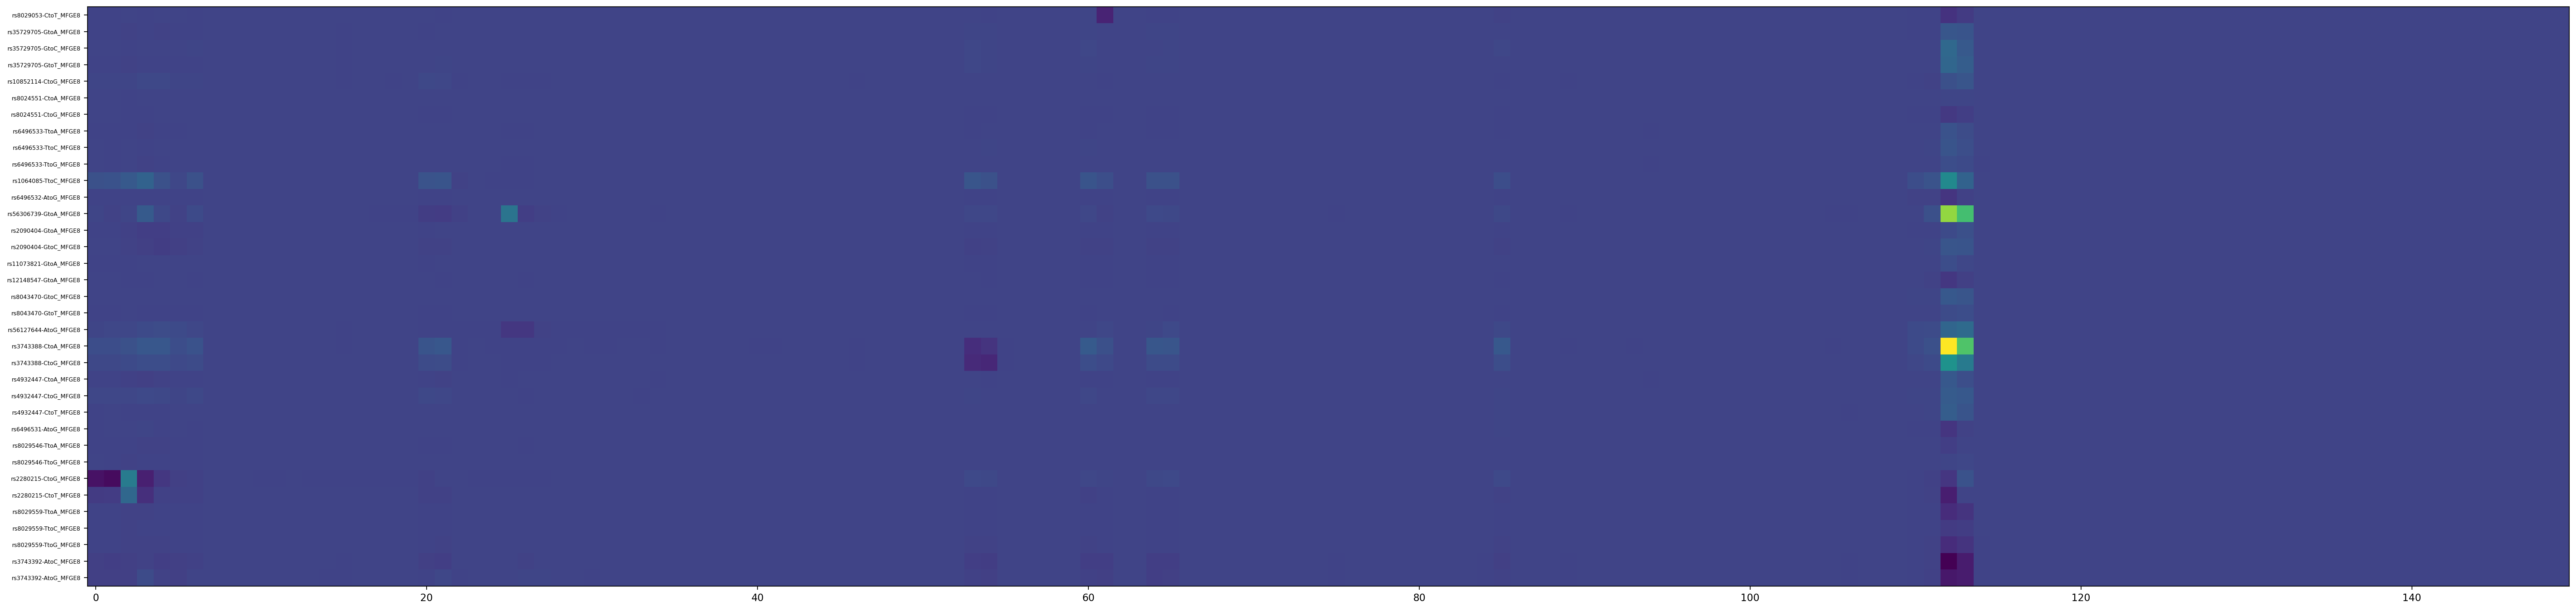

In [87]:
fig, ax =plt.subplots(figsize=(45,25))

tmp=pd.DataFrame()
for x in enformer_keys_no_ref:
  tmp[x]=enformer_results[x][450:600,4]-enformer_results['reference_MFGE8'][450:600,4]

ax.imshow(tmp.T)
ax.set_yticks(range(len(tmp.columns)))
ax.set_yticklabels(tmp.columns, size='xx-small')


In [42]:
enformer_results['rs8029053-CtoT_MFGE8']

array([[0.1432438 , 0.01074604, 0.0119438 , ..., 0.02922719, 0.0011407 ,
        0.00766246],
       [0.06724801, 0.01048493, 0.01120851, ..., 0.02417649, 0.00136909,
        0.00906281],
       [0.13101374, 0.01412153, 0.01498335, ..., 0.02668785, 0.00178477,
        0.01090073],
       ...,
       [0.12952201, 0.06850097, 0.07809926, ..., 0.06129663, 0.00508676,
        0.02866158],
       [0.00692095, 0.00321285, 0.00349068, ..., 0.00418876, 0.00050555,
        0.00207191],
       [0.01285756, 0.00597216, 0.00646541, ..., 0.006476  , 0.00057068,
        0.00675916]], dtype=float32)

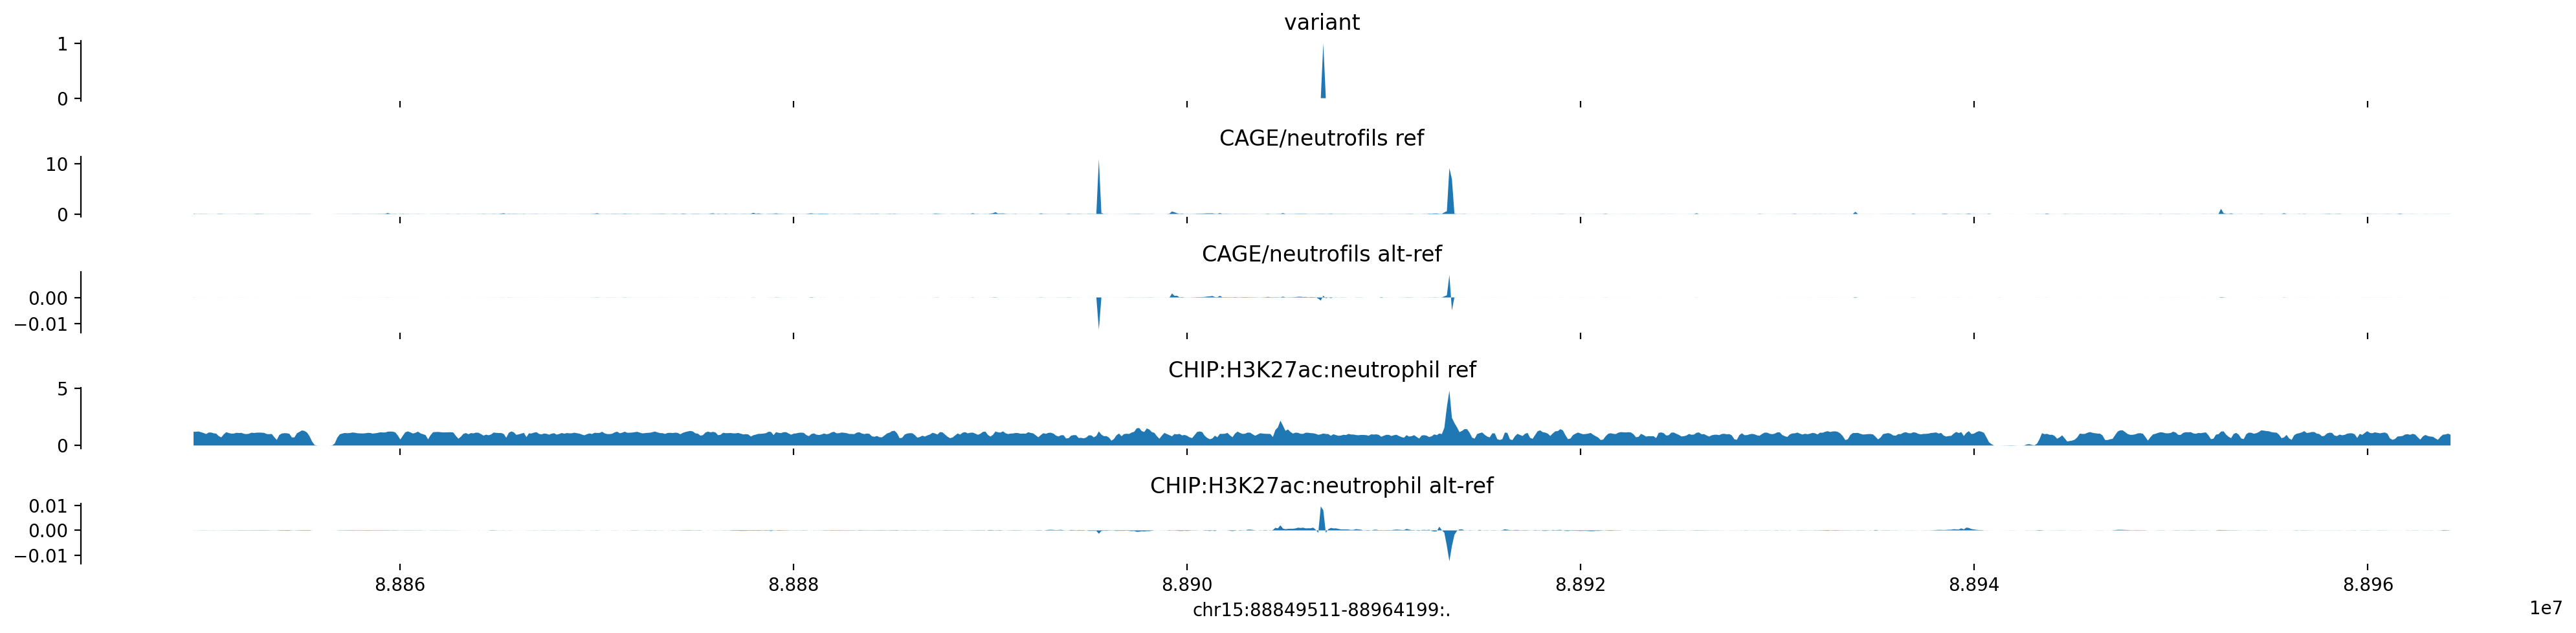

In [18]:
# @title Visualize some tracks
variant_track = np.zeros_like(reference_prediction[:, 0], dtype=bool)
variant_track[variant_track.shape[0] // 2] = True
tracks = {'variant': variant_track,
          'CAGE/neutrofils ref': reference_prediction[:, 4767],
          'CAGE/neutrofils alt-ref': alternate_prediction[:, 4767] - reference_prediction[:, 4767],
          'CHIP:H3K27ac:neutrophil ref': reference_prediction[:, 2280],
          'CHIP:H3K27ac:neutrophil alt-ref': alternate_prediction[:, 2280] - reference_prediction[:, 2280],
          }

plot_tracks(tracks, interval.resize(reference_prediction.shape[0] * 128), height=1)

In [27]:

df_targets['modality']=[x.split(':')[0] for x in df_targets['description']]
df_targets['target']=[x.split(':')[1] for x in df_targets['description']]
df_targets

,index,genome,identifier,file,clip,scale,sum_stat,description,modality,target
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...,DNASE,cerebellum male adult (27 years) and male adul...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...,DNASE,frontal cortex male adult (27 years) and male ...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion,DNASE,chorion
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...,DNASE,Ishikawa treated with 0.02% dimethyl sulfoxide...
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348,DNASE,GM03348
...,...,...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R,CAGE,epithelioid sarcoma cell line
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...,CAGE,squamous cell lung carcinoma cell line
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS,CAGE,gastric cancer cell line
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727,CAGE,carcinoid cell line


In [29]:

df_targets[df_targets['modality']=='CAGE']

,index,genome,identifier,file,clip,scale,sum_stat,description,modality,target
4675,4675,0,CNhs10608,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
4676,4676,0,CNhs10610,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:SABiosciences XpressRef Human Universal T...,CAGE,SABiosciences XpressRef Human Universal Total ...
4677,4677,0,CNhs10612,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:Universal RNA - Human Normal Tissues Bioc...,CAGE,"Universal RNA - Human Normal Tissues Biochain,..."
4678,4678,0,CNhs10615,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:adipose tissue, adult, pool1",CAGE,"adipose tissue, adult, pool1"
4679,4679,0,CNhs10616,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,"CAGE:bladder, adult, pool1",CAGE,"bladder, adult, pool1"
...,...,...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R,CAGE,epithelioid sarcoma cell line
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...,CAGE,squamous cell lung carcinoma cell line
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS,CAGE,gastric cancer cell line
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727,CAGE,carcinoid cell line


## Score variants in a VCF file

### Report top 20 PCs

In [ ]:
enformer_score_variants = EnformerScoreVariantsPCANormalized(model_path, transform_path, num_top_features=20)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TruncatedSVD from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at yo

In [ ]:
# Score the first 5 variants from ClinVar
# Lower-dimensional scores (20 PCs)
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'PC{i}': score for i, score in enumerate(variant_scores)}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,chr1,925952,1019397,G,A,13.865371,9.379375,1.322473,7.198019,11.926774,-4.407538,-5.878580,-10.701156,-3.140507,2.994015,4.716916,1.098637,2.569388,13.693736,8.564518,9.383035,-2.159512,-9.733231,7.727090,-0.669298
1,chr1,930188,846933,G,A,-61.468933,-5.653942,-2.758731,6.289482,1.844845,3.446712,6.052454,0.632046,2.584915,1.117951,1.942497,-6.513691,-4.948788,-1.172066,-2.903700,0.482835,2.896945,1.757883,3.686084,-6.673547
2,chr1,930200,1043045,G,A,-61.995975,-10.007704,-0.312641,10.605079,-5.349404,-2.555728,7.008485,9.793589,-14.216670,4.411201,0.295830,-4.968991,-10.770261,-1.512434,0.186349,7.461446,5.153117,4.041459,0.512155,-2.865725
3,chr1,930203,972363,C,T,21.486368,-9.248886,3.684767,9.606424,0.538447,5.264496,1.418155,-14.005326,12.898662,9.391730,-5.201692,-3.091272,1.975370,-5.240757,-14.367105,-7.802942,0.138479,12.087408,-5.559704,9.171222
4,chr1,930222,998906,GAACTC,TTCTTCTG,13.672197,181.645172,-302.586548,184.414001,146.373199,284.204163,-108.902489,100.794731,-205.568008,302.769409,203.416458,111.947685,-61.380695,222.271515,152.539993,114.129166,-26.604349,-68.656372,-36.595196,38.175354


### Report all 5,313 features (z-score normalized)

In [ ]:
enformer_score_variants_all = EnformerScoreVariantsNormalized(model_path, transform_path)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TruncatedSVD from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
# Score the first 5 variants from ClinVar
# All Scores
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants_all.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'{i}_{name[:20]}': score for i, (name, score) in enumerate(zip(df_targets.description, variant_scores))}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,DNASE:cerebellum mal,DNASE:frontal cortex,DNASE:chorion,DNASE:Ishikawa treat,DNASE:GM03348,DNASE:GM03348 geneti,DNASE:AG08395,DNASE:AG08396,DNASE:AG20443,DNASE:H54,DNASE:GM10248,DNASE:GM12878,DNASE:GM12891,DNASE:GM12892,DNASE:GM18507,DNASE:GM19238,DNASE:GM19239,DNASE:GM19240,DNASE:H1-hESC,DNASE:H7-hESC,DNASE:H9,DNASE:heart male adu,DNASE:HEK293T,DNASE:HeLa-S3 treate,DNASE:HeLa-S3,DNASE:hepatocyte,DNASE:HepG2,DNASE:HTR-8/SVneo,DNASE:endothelial ce,DNASE:CWRU1 male,DNASE:iPS-NIHi11 mal,DNASE:iPS-NIHi7 fema,DNASE:K562 treated w,DNASE:K562 G2 phase,DNASE:K562 G1 phase,...,CAGE:CD14+CD16- Mono,CAGE:achilles tendon,CAGE:cerebrospinal f,CAGE:cruciate ligame,CAGE:eye - vitreous,CAGE:eye - muscle su,CAGE:eye - muscle la,CAGE:eye - muscle me,CAGE:eye - muscle in,CAGE:Fingernail (inc,"CAGE:optic nerve,","CAGE:Skin - palm,",CAGE:tongue epidermi,"CAGE:Urethra,",CAGE:CD14+ monocytes,CAGE:Hep-2 cells tre,CAGE:Hep-2 cells moc,CAGE:immature langer,CAGE:migratory lange,CAGE:CD34 cells diff,CAGE:amygdala - adul,CAGE:thalamus - adul,CAGE:hippocampus - a,CAGE:parietal lobe -,CAGE:cerebellum - ad,CAGE:pineal gland -,CAGE:spinal cord - a,CAGE:Olfactory epith,CAGE:gamma delta pos,"CAGE:Mast cell, expa","CAGE:adipose,","CAGE:cerebellum, new","CAGE:spinal cord, ne","CAGE:amygdala, newbo","CAGE:hippocampus, ne","CAGE:putamen, newbor","CAGE:thalamus, newbo",CAGE:thymic carcinom,CAGE:Smooth muscle c,CAGE:parietal cortex
0,chr1,925952,1019397,G,A,-3.953313,-2.132398,-1.133056,-0.018265,-7.324341,-5.928950,-2.696301,-2.234811,-1.869620,16.743450,2.218565,3.167206,1.084149,0.671318,6.513158,0.971147,6.255165,5.352125,1.729454,-3.350782,1.896389,-1.563089,-2.268677,11.647644,14.272476,-7.074303,1.850793,5.803924,0.381484,-0.443644,-0.299062,-0.139204,-8.861604,-8.072408,-6.212577,...,-0.046439,4.083508,3.535412,11.717014,-5.239547,1.081644,2.213174,0.853902,-0.216257,2.654844,0.402727,1.567667,3.049335,1.010953,-0.800231,157.583069,172.648773,0.576450,5.026437,0.464598,2.133233,1.689052,2.324542,1.849092,-1.319847,-25.130344,2.456997,11.093707,-4.529293,5.072914,-6.317924,-2.482907,1.591787,-5.362659,0.643638,-1.936050,2.499822,12.372701,23.365688,2.915666
1,chr1,930188,846933,G,A,-1.791559,-15.679683,-22.533566,0.523771,-3.826311,-3.219894,-2.668196,-9.468966,-3.158970,-7.704255,-3.150757,-0.523286,-11.126574,-11.116987,-3.674609,-8.464477,-11.757355,-8.595486,-0.536293,0.227047,-0.779173,-15.736004,0.879350,-6.572251,-4.200795,-8.630462,-0.465244,-3.442806,-0.311721,-4.801476,-5.145035,-1.415882,0.362791,-1.997213,-2.307346,...,-33.052082,-2.994223,-8.416894,-5.190420,-4.534584,-5.453042,-3.034095,-7.163062,-2.291493,-8.985706,-4.789318,-4.794244,-1.449592,-1.989321,-22.916094,-35.752350,-35.275730,-13.375345,-28.358622,-31.596754,-11.371334,-9.254264,-9.006978,-9.230368,-3.783889,-0.283448,-12.094806,-59.170837,-66.303123,-34.475914,-21.272675,-4.328580,-16.075752,-6.281566,-10.389462,-6.422119,-9.181828,-14.224935,-46.487968,-11.499000
2,chr1,930200,1043045,G,A,-0.526763,-14.688834,-17.484657,2.908407,2.734465,3.514852,0.294236,-4.154023,1.062205,-7.452735,-2.387097,-0.988034,-7.148329,-7.479169,-3.070057,-9.537191,-12.243765,-10.340226,0.070186,0.338647,-0.706960,-13.103579,3.004640,-8.224607,-7.412826,-9.011602,0.814177,-2.572933,0.154302,-4.661432,-3.152854,-1.105172,-2.336678,-4.403462,-4.830977,...,-26.200890,-4.082983,-11.688838,-5.358507,-5.728800,-6.592316,-5.169149,-8.596480,-3.361437,-6.800953,-4.874091,-4.676669,-2.054912,-2.659639,-19.059345,-86.237938,-90.280151,-13.633442,-32.443680,-19.412699,-7.266642,-7.957299,-6.725488,-6.803071,-6.814243,1.440345,-8.739142,-70.331505,-39.735146,-31.107134,-18.125492,-3.016214,-8.161813,-12.665734,-9.362435,-5.167178,-3.976753,-12.334543,-38.066742,-8.078856
3,chr1,930203,972363,C,T,3.887291,-0.802319,-1.669034,4.747784,1.695362,2.217486,-0.282765,-1.139245,0.368520,-3.772724,3.466754,1.096701,2.536208,5.108255,1.874467,3.965143,1.232345,3.818713,0.651470,2.554193,0.991104,1.639103,